# Query Expansion
Query expansion consists of asking an LLM to produce a number of similar queries to a user query. We are then able to use each of these queries in the retrieval process, increasing the number and relevance of retrieved documents.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import rich

from dotenv import load_dotenv

load_dotenv()

#HF_API_TOKEN = os.getenv("HF_API_TOKEN")
OPENAI_API_TOKEN = os.getenv("OPENAI_API_TOKEN")

For this notebook we will use an InMemoryDocumentStore with document imported from wikipedia

In [2]:
import json

from typing import List, Optional
from haystack import Pipeline, component
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.dataclasses import Document

from haystack.utils import Secret

## The Process of Query Expansion

First, let's create a `QueryExpander`. This component is going to be able to create a `number` (defaults to 5) of additional queries, similar to the original user query. It returns `queries` that has the original query + `number` of similar queries.

In [13]:
@component
class QueryExpander:

    def __init__(self, open_ai_key: str , prompt: Optional[str] = None, model: str = "gpt-4o-mini"):

        self.query_expansion_prompt = prompt
        self.model = model
        self.open_ai_key = open_ai_key
        if prompt == None:
          self.query_expansion_prompt = """
          You are part of an information system that processes users queries.
          You expand a given query into {{ number }} queries that are similar in meaning.

          Structure:
          Follow the structure shown below in examples to generate expanded queries.
          Examples:
          1. Example Query 1: "climate change effects"
          Example Expanded Queries: ["impact of climate change", "consequences of global warming", "effects of environmental changes"]

          2. Example Query 2: ""machine learning algorithms""
          Example Expanded Queries: ["neural networks", "clustering", "supervised learning", "deep learning"]

          Your Task:
          Query: "{{query}}"
          Example Expanded Queries:
          """
        builder = PromptBuilder(self.query_expansion_prompt)
        llm = OpenAIGenerator(model = self.model, api_key = self.open_ai_key)
        self.pipeline = Pipeline()
        self.pipeline.add_component(name="builder", instance=builder)
        self.pipeline.add_component(name="llm", instance=llm)
        self.pipeline.connect("builder", "llm")

    @component.output_types(queries=List[str])
    def run(self, query: str, number: int = 5):
        result = self.pipeline.run({'builder': {'query': query, 'number': number}})
        expanded_query = json.loads(result['llm']['replies'][0]) + [query]
        return result, expanded_query, {"queries": list(expanded_query)}

In [17]:
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchEmbeddingRetriever
from haystack.components.embedders import SentenceTransformersTextEmbedder

In [18]:
document_store = ElasticsearchDocumentStore(hosts = "http://localhost:9200")

## Retrieval Without Query Expansion

In [35]:
embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
retriever = ElasticsearchEmbeddingRetriever(document_store=document_store, top_k = 3)

In [36]:
retrieval_pipeline = Pipeline()
retrieval_pipeline.add_component("query_embedder", embedder)
retrieval_pipeline.add_component("embedding_retriever", retriever)

retrieval_pipeline.connect("query_embedder.embedding", "embedding_retriever.query_embedding")

🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - embedding_retriever: ElasticsearchEmbeddingRetriever
🛤️ Connections
  - query_embedder.embedding -> embedding_retriever.query_embedding (List[float])

In [38]:
query = "Tolkien"
retrieval_pipeline.run({"query_embedder":{ "text": query}, "embedding_retriever":{"top_k": 3}})

Batches: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


{'embedding_retriever': {'documents': [Document(id=6f53b71ce1a8f2dfca90f2f97a7260b64c17d239e1bd80719a50158c814e6416, content: ' Tolkien’s commitment to creating a believable and immersive world sets him apart from other fantasy...', meta: {'file_path': 'data/tolkien.txt', 'source_id': 'b4dd8cf407a5c9917b7a435288375829a0f32fa11e2064c64fc88dedbbe906b5', 'page_number': 1, 'split_id': 24, 'split_idx_start': 3136}, score: 0.8195174, embedding: vector of size 384),
   Document(id=abfcbed8a42e97badf0cc083137d25716117aa35777db1920d0ce61ce9d1c6a0, content: '
   
   Following the success of *The Hobbit*, Tolkien set out to expand his universe through the writin...', meta: {'file_path': 'data/tolkien.txt', 'source_id': 'b4dd8cf407a5c9917b7a435288375829a0f32fa11e2064c64fc88dedbbe906b5', 'page_number': 1, 'split_id': 17, 'split_idx_start': 2183}, score: 0.81605506, embedding: vector of size 384),
   Document(id=69a67d2edd35fa3418aac24a2a2849b2b75f2a7d73741f255fb2e0f0619e08c6, content: '
   
   Tolk

## Retrieval With Query Expansion

Now let's have a look at what documents we are able to retrieve if we are to inluce query expansion in the process. For this step, let's create a `MultiQueryElasticEmbeddingRetriever` that is able to use embedding retrieval for each (expansded) query in turn.

This component also handles the same document being retrieved for multiple queries and will not return duplicates.

In [83]:
@component
class MultiQueryElasticsearchEmbeddingRetriever:

    def __init__(self, retriever: ElasticsearchEmbeddingRetriever,  top_k: int = 3):
        self.retriever = retriever
        self.embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
        self.results = []
        self.ids = set()
        self.top_k = top_k

        self.pipeline = Pipeline()
        self.pipeline.add_component(name="embedder", instance=self.embedder)
        self.pipeline.add_component(name="retriever", instance=self.retriever)
        self.pipeline.connect("embedder", "retriever")
        

    def add_document(self, document: Document):
        if document.id not in self.ids:
            self.results.append(document)
            self.ids.add(document.id)

    @component.output_types(documents=List[Document])
    def run(self, queries: List[str], top_k: int = None):
        if top_k != None:
          self.top_k = top_k
        for query in queries:
          result = self.pipeline.run({"embedder": {'text':query}, "retriever": {"top_k": self.top_k}})
          for doc in result['retriever']['documents']:
            self.add_document(doc)
        self.results.sort(key=lambda x: x.score, reverse=True)
        return {"documents": self.results}

In [84]:
query_expander = QueryExpander(open_ai_key=Secret.from_token(OPENAI_API_TOKEN))

retriever = MultiQueryElasticsearchEmbeddingRetriever(ElasticsearchEmbeddingRetriever(document_store=document_store, top_k = 5))

expanded_retrieval_pipeline = Pipeline()
expanded_retrieval_pipeline.add_component("expander", query_expander)
expanded_retrieval_pipeline.add_component("embedding_retriever", retriever)

expanded_retrieval_pipeline.connect("expander.queries", "embedding_retriever.queries")

🚅 Components
  - expander: QueryExpander
  - embedding_retriever: MultiQueryElasticsearchEmbeddingRetriever
🛤️ Connections
  - expander.queries -> embedding_retriever.queries (List[str])

In [85]:
expanded_retrieval_pipeline.run({"expander": {"query": query}}, include_outputs_from=["expander"])

Batches: 100%|██████████| 1/1 [00:00<00:00, 19.11it/s]


{'embedding_retriever': {'documents': [Document(id=43bf6a2249a1150b06d86871008a411807102d62a54a190b378e240c55e195ee, content: ' *The Hobbit* was well-received, quickly becoming a beloved classic and establishing Tolkien as a pr...', meta: {'file_path': 'data/tolkien.txt', 'source_id': 'b4dd8cf407a5c9917b7a435288375829a0f32fa11e2064c64fc88dedbbe906b5', 'page_number': 1, 'split_id': 16, 'split_idx_start': 2068}, score: 0.8676643, embedding: vector of size 384),
   Document(id=882b15e73d8077681ec745b6852ed92067e2e1c4a8c7cd2f3b47131f5e177935, content: '
   
   In addition to his fiction, Tolkien wrote extensively about his creative process and the philoso...', meta: {'file_path': 'data/tolkien.txt', 'source_id': 'b4dd8cf407a5c9917b7a435288375829a0f32fa11e2064c64fc88dedbbe906b5', 'page_number': 1, 'split_id': 25, 'split_idx_start': 3298}, score: 0.82914317, embedding: vector of size 384),
   Document(id=ca6a348ded6cfe4d13cfd340d5d12cbdc01a1345c680ff4adbfd49d1ed08edcf, content: 'John Ronald 

## Query Expansion for RAG

### RAG without Query Expansion

In [86]:
template = """
You are part of an information system that summarises related documents.
You answer a query using the textual content from the documents retrieved for the
following query.

You should reference the documents you used to support your answer.
###
Original Query: "{{query}}"
Retrieved Documents: {{documents}}
Summary Answer:
"""
embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
retriever = ElasticsearchEmbeddingRetriever(document_store=document_store, top_k = 3)
prompt_builder = PromptBuilder(template = template)
llm = OpenAIGenerator(api_key=Secret.from_token(OPENAI_API_TOKEN))

rag_pipeline = Pipeline()
rag_pipeline.add_component("embedder", embedder)
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt", prompt_builder)
rag_pipeline.add_component("llm", llm)

rag_pipeline.connect("embedder.embedding", "retriever.query_embedding")
rag_pipeline.connect("retriever.documents", "prompt.documents")
rag_pipeline.connect("prompt", "llm")

🚅 Components
  - embedder: SentenceTransformersTextEmbedder
  - retriever: ElasticsearchEmbeddingRetriever
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> llm.prompt (str)

In [87]:
query = "Tolkien"
res = rag_pipeline.run({"embedder": {"text": query}, "retriever": {"top_k": 3}}, include_outputs_from=["retriever"])
rich.print(res["llm"]["replies"])

Batches: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


[
    "J.R.R. Tolkien is distinguished by his dedication to crafting a believable and immersive world, which is a 
hallmark of his works. His initial success with *The Hobbit* motivated him to further develop his universe through 
expansive writing. Tolkien's early relationship with nature and literature ignited a lasting passion for 
storytelling, contributing significantly to his narrative approach and themes (Document id: 
6f53b71ce1a8f2dfca90f2f97a7260b64c17d239e1bd80719a50158c814e6416; Document id: 
abfcbed8a42e97badf0cc083137d25716117aa35777db1920d0ce61ce9d1c6a0; Document id: 
69a67d2edd35fa3418aac24a2a2849b2b75f2a7d73741f255fb2e0f0619e08c6)."
]

### RAG with Query Expansion

In [90]:
template = """
You are part of an information system that summarises related documents.
You answer a query using the textual content from the documents retrieved for the
following query.

You should reference the documents you used to support your answer.
###
Original Query: "{{query}}"
Retrieved Documents: {{documents}}
Summary Answer:
"""
expander = QueryExpander(open_ai_key=Secret.from_token(OPENAI_API_TOKEN))
query_retriever = MultiQueryElasticsearchEmbeddingRetriever(ElasticsearchEmbeddingRetriever(document_store=document_store, top_k = 5))
prompt_builder = PromptBuilder(template = template)
llm = OpenAIGenerator(api_key=Secret.from_token(OPENAI_API_TOKEN))

query_expanded_rag_pipeline = Pipeline()
query_expanded_rag_pipeline.add_component("expander", expander)
query_expanded_rag_pipeline.add_component("retriever", query_retriever)
query_expanded_rag_pipeline.add_component("prompt", prompt_builder)
query_expanded_rag_pipeline.add_component("llm", llm)

query_expanded_rag_pipeline.connect("expander.queries", "retriever.queries")
query_expanded_rag_pipeline.connect("retriever.documents", "prompt.documents")
query_expanded_rag_pipeline.connect("prompt", "llm")

🚅 Components
  - expander: QueryExpander
  - retriever: MultiQueryElasticsearchEmbeddingRetriever
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - expander.queries -> retriever.queries (List[str])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> llm.prompt (str)

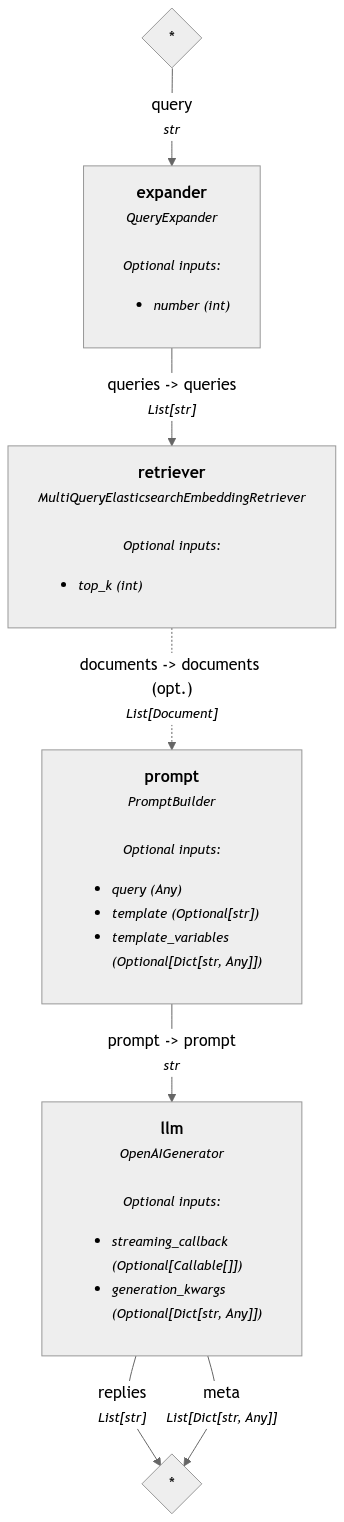

In [91]:
query_expanded_rag_pipeline.show()

In [ ]:
query = "Tolkien"
res = query_expanded_rag_pipeline.run({"expander": {"query": query}, "retriever": {"top_k": 3}}, include_outputs_from=["retriever", "expander"])

rich.print(res['llm']['replies'])
print("Expander: ", res['expander'])
print("Retriver: ", res['retriever'])

Batches: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


[
    "John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is celebrated for his 
impact on fantasy literature, notably through his works such as *The Hobbit* and *The Lord of the Rings*. His first
major published work, *The Hobbit*, released in 1937, follows Bilbo Baggins— a reluctant hobbit who embarks on an 
unexpected adventure (Document 487a58365267f108dd8ff523056a33f51d30c40580cb528cca7ffd7b8759c884). This book quickly
became a beloved classic, establishing Tolkien's reputation as a prominent author in the genre (Document 
43bf6a2249a1150b06d86871008a411807102d62a54a190b378e240c55e195ee).\n\nTolkien's works are distinguished by their 
intricate mythology and depth, diverging significantly in tone and complexity. While *The Hobbit* was primarily 
aimed at children, *The Lord of the Rings* explores darker themes and is recognized for its elaborate 
world-building, including detailed histories, languages, and cultures (Document 
a306633ab1b1f5af96f0297d53c7c74ea5d09b1b391fab033a02439b4ea223e0; Document 
a6e3f37ba2c3716bd6a1c8b5b669a890e3f5f317e6c544db170451fa558b37be).\n\nTolkien's journey through literature was not 
without challenges, facing criticism from literary circles (Document 
25257a0ac1d4297ce427459960ef927a8183752530d85947bca66119f3e0fe39). However, his belief in the power of myth and 
storytelling to convey moral truths has left a lasting legacy in the literary world (Document 
8252051f60c1af773fbadb1e6dcf205d3caeae184a2401dab706a1f5ce06a984). \n\nAfter the success of *The Hobbit*, Tolkien 
expanded his universe with *The Lord of the Rings*, which follows Frodo Baggins and his companions on a perilous 
journey to destroy the One Ring (Document 2f2f5d20e48f9f3f88da1b9d802e85b04132f5b4e0aff1299b3880dfa880dbc7). 
Tolkien’s extensive writings encompass not only narratives but also reflections on his creative process, showcasing
his deep engagement with the craft of storytelling (Document 
882b15e73d8077681ec745b6852ed92067e2e1c4a8c7cd2f3b47131f5e177935)."
]

{'queries': ['J.R.R. Tolkien', "Tolkien's works", 'Middle-earth legendarium', 'The Hobbit and The Lord of the Rings', "Tolkien's literary contributions", 'Tolkien']}
{'documents': [Document(id=882b15e73d8077681ec745b6852ed92067e2e1c4a8c7cd2f3b47131f5e177935, content: '

In addition to his fiction, Tolkien wrote extensively about his creative process and the philoso...', meta: {'file_path': 'data/tolkien.txt', 'source_id': 'b4dd8cf407a5c9917b7a435288375829a0f32fa11e2064c64fc88dedbbe906b5', 'page_number': 1, 'split_id': 25, 'split_idx_start': 3298}, score: 0.8656961, embedding: vector of size 384), Document(id=a2147d999b230318d50b566d2de0921226dbfcf3baadcb6b4b79338ee8cfce34, content: ' The cinematic adaptations of *The Lord of the Rings* and *The Hobbit*, directed by Peter Jackson, b...', meta: {'file_path': 'data/tolkien.txt', 'source_id': 'b4dd8cf407a5c9917b7a435288375829a0f32fa11e2064c64fc88dedbbe906b5', 'page_number': 1, 'split_id': 37, 'split_idx_start': 4677}, score: 0.8557259, emb